For interactive maps, please follow this link: https://eu-gb.dataplatform.cloud.ibm.com/analytics/notebooks/v2/72f6f95a-ef93-43de-88a9-f7f4ef50c494/view?access_token=9014be125f0337bc59df6349ec3b6ed29a789adba7cda2d5bbf831c57c20697c

# Introduction: Overview of Traffic Accident Prediction Capstone Project

In this project I will build up a prediction modell about the **outcome of traffic car accidents**.

The base of my analysis is the accident report of the **Seattle Police Department**. This report contains the historical data of every accident since 2004, a collection of 194 thousand events, categorizing the accidents by the dates and daytimes, circumstances, participants, etc., and telling the **severity of the outcome**: whether there was only a property damage or personal injury also happened.


## Business Problem

### Who and how can utilize the findings of our predictions? 

First and foremost we expect to have an actionable list for the **Seattle Police Department**:

- knowing _where_ the severe accidents happen, they can implement precautionary steps, like changing traffic tables, continuous presence, speed limits, etc
- knowing what are the components of a possibly severe accident, they can initate targeted checks, like alcohol/drug tests, etc

Besides the Police, **Insurance companies** would also profit from our predictions:

- they might raise the insurance fees for the habitants of risky areas
- they might calculate insurance fees for personal injuries
- they also will have insight on bicycle users' traffic risks

Coming to the risks, **real estate agents** or **prospective buyers** could also consider worthful to being aware of the safest areas. 


## The Data

The source of the data is the Seattle Police Department.

The raw data contains 38 columns and 194674 rows.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Import clean data 
path = 'https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv'
df = pd.read_csv(path)

df.head()

SEVERITYCODE           X          Y  OBJECTID  INCKEY  COLDETKEY REPORTNO  \
0             2 -122.323148  47.703140         1    1307       1307  3502005   
1             1 -122.347294  47.647172         2   52200      52200  2607959   
2             1 -122.334540  47.607871         3   26700      26700  1482393   
3             1 -122.334803  47.604803         4    1144       1144  3503937   
4             2 -122.306426  47.545739         5   17700      17700  1807429   

    STATUS      ADDRTYPE   INTKEY  ... ROADCOND                LIGHTCOND  \
0  Matched  Intersection  37475.0  ...      Wet                 Daylight   
1  Matched         Block      NaN  ...      Wet  Dark - Street Lights On   
2  Matched         Block      NaN  ...      Dry                 Daylight   
3  Matched         Block      NaN  ...      Dry                 Daylight   
4  Matched  Intersection  34387.0  ...      Wet                 Daylight   

  PEDROWNOTGRNT  SDOTCOLNUM SPEEDING ST_COLCODE  \
0           NaN         NaN      NaN         10   
1           NaN   6354039.0      NaN         11   
2           NaN   4323031.0      NaN         32   
3           NaN         NaN      NaN         23   
4           NaN   4028032.0      NaN         10   

                                          ST_COLDESC  SEGLANEKEY  \
0                                  Entering at angle           0   
1  From same direction - both going straight - bo...           0   
2                             One parked--one moving           0   
3                   From same direction - all others           0   
4                                  Entering at angle           0   

   CROSSWALKKEY  HITPARKEDCAR  
0             0             N  
1             0             N  
2             0             N  
3             0             N  
4             0             N  

[5 rows x 38 columns]

In [2]:
print(df.dtypes)

SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

## First sight of the data

- Severity code = 2, if personal injury occured during the accident; 1 in case if only property damage
- We have X and Y coordinates for the accidents, X is Longitude, Y is Latitude; a quick search shows
- We have the data and the time recorded for the accidents
- We know howmany injured was involved
- We have data about bikers and pedestrians involved
- We have lots of information about the circumstances:
    1. Weather
    2. Road condition
    3. Light condition
    4. Had the pedestrian advance
    5. Was the driver speeding
    6. Did the accident happen in an Intersection, midblock, highway, etc.

## Preparing data

### Renaming columns to verbose names

Most of the column names speak for themselves, however we would like to have a more pleasant format at least for those ones which will be used in the analysis.

\+ Converting time columns to the proper format

In [3]:
df.rename(columns = {'SEVERITYCODE':'Severity_level','SEVERITYDESC':'Severity_desc', 'ADDRTYPE':'Location_type','LOCATION':'Location','COLLISIONTYPE':'Collision_type','PERSONCOUNT':'Affected_persons','PEDCOUNT':'Affected_pedestrians','PEDCYLCOUNT':'Affected_bikers','VEHCOUNT':'Affected_vehicles','INCDATE':'Accident_date','INCDTTM':'Accident_time','JUNCTIONTYPE':'Junctiontype','SDOT_COLCODE':'Accident_code','SDOT_COLDESC':'Accident_desc','INATTENTIONIND':'Inattention','UNDERINFL':'Under_influence','WEATHER':'Weather','ROADCOND':'Road_condition','LIGHTCOND':'Light_condition','PEDROWNOTGRNT':'Pedestrian_right','SPEEDING':'Speeding','ST_COLCODE':'Collision_code','ST_COLDESC':'Collision_description'}, inplace = True)

df['Accident_date'] = pd.to_datetime(df['Accident_date'])
df['Accident_time'] = pd.to_datetime(df['Accident_time'])


## Calculating new columns

Let's check whether there is a correlation between the **season** (spring, summer, fall, winter) and the **daytime** (morning, day, night) when compared to the accidents.

For this we add two new columns, calculated by **Accident_date** and **Accident_time**

In [4]:
# Adding Seasons - I add them next to coordinates to be visible

df.insert(3,"Season", "")

import datetime

def calc_season(doy):
    if doy.month > 2 and doy.month < 6:
      season = 'spring'
    elif doy.month < 9:
      season = 'summer'
    elif doy.month < 12:
      season = 'fall'
    else:
      season = 'winter'
    
    return season

df['Season'] = df.apply(lambda x: calc_season(x['Accident_date']),axis=1)

df.head()


Severity_level           X          Y  Season  OBJECTID  INCKEY  COLDETKEY  \
0               2 -122.323148  47.703140  spring         1    1307       1307   
1               1 -122.347294  47.647172  winter         2   52200      52200   
2               1 -122.334540  47.607871    fall         3   26700      26700   
3               1 -122.334803  47.604803  spring         4    1144       1144   
4               2 -122.306426  47.545739  summer         5   17700      17700   

  REPORTNO   STATUS Location_type  ...  Road_condition  \
0  3502005  Matched  Intersection  ...             Wet   
1  2607959  Matched         Block  ...             Wet   
2  1482393  Matched         Block  ...             Dry   
3  3503937  Matched         Block  ...             Dry   
4  1807429  Matched  Intersection  ...             Wet   

           Light_condition Pedestrian_right SDOTCOLNUM  Speeding  \
0                 Daylight              NaN        NaN       NaN   
1  Dark - Street Lights On              NaN  6354039.0       NaN   
2                 Daylight              NaN  4323031.0       NaN   
3                 Daylight              NaN        NaN       NaN   
4                 Daylight              NaN  4028032.0       NaN   

  Collision_code                              Collision_description  \
0             10                                  Entering at angle   
1             11  From same direction - both going straight - bo...   
2             32                             One parked--one moving   
3             23                   From same direction - all others   
4             10                                  Entering at angle   

   SEGLANEKEY  CROSSWALKKEY  HITPARKEDCAR  
0           0             0             N  
1           0             0             N  
2           0             0             N  
3           0             0             N  
4           0             0             N  

[5 rows x 39 columns]

In [10]:
# Adding daytimes - in which hour the accident happened, like early morning, in the night, etc.

df.insert(4,"Daytime", "")

def calc_hour(tod):
    return tod.hour

df['Daytime'] = df.apply(lambda x: calc_hour(x['Accident_time']), axis =1)

df.head()

Severity_level           X          Y  Season  Daytime  OBJECTID  INCKEY  \
0               2 -122.323148  47.703140  spring       14         1    1307   
1               1 -122.347294  47.647172  winter       18         2   52200   
2               1 -122.334540  47.607871    fall       10         3   26700   
3               1 -122.334803  47.604803  spring        9         4    1144   
4               2 -122.306426  47.545739  summer        8         5   17700   

   COLDETKEY REPORTNO   STATUS  ... Road_condition          Light_condition  \
0       1307  3502005  Matched  ...            Wet                 Daylight   
1      52200  2607959  Matched  ...            Wet  Dark - Street Lights On   
2      26700  1482393  Matched  ...            Dry                 Daylight   
3       1144  3503937  Matched  ...            Dry                 Daylight   
4      17700  1807429  Matched  ...            Wet                 Daylight   

  Pedestrian_right SDOTCOLNUM Speeding  Collision_code  \
0              NaN        NaN      NaN              10   
1              NaN  6354039.0      NaN              11   
2              NaN  4323031.0      NaN              32   
3              NaN        NaN      NaN              23   
4              NaN  4028032.0      NaN              10   

                               Collision_description SEGLANEKEY  CROSSWALKKEY  \
0                                  Entering at angle          0             0   
1  From same direction - both going straight - bo...          0             0   
2                             One parked--one moving          0             0   
3                   From same direction - all others          0             0   
4                                  Entering at angle          0             0   

   HITPARKEDCAR  
0             N  
1             N  
2             N  
3             N  
4             N  

[5 rows x 40 columns]

In [5]:
# Adding daytimes - in which hour the accident happened, like early morning, in the night, etc.

df.insert(4,"Month", "")

def calc_month(tod):
    return tod.month

df['Month'] = df.apply(lambda x: calc_month(x['Accident_time']), axis =1)

df.head()

Severity_level           X          Y  Season  Month  OBJECTID  INCKEY  \
0               2 -122.323148  47.703140  spring      3         1    1307   
1               1 -122.347294  47.647172  winter     12         2   52200   
2               1 -122.334540  47.607871    fall     11         3   26700   
3               1 -122.334803  47.604803  spring      3         4    1144   
4               2 -122.306426  47.545739  summer      1         5   17700   

   COLDETKEY REPORTNO   STATUS  ... Road_condition          Light_condition  \
0       1307  3502005  Matched  ...            Wet                 Daylight   
1      52200  2607959  Matched  ...            Wet  Dark - Street Lights On   
2      26700  1482393  Matched  ...            Dry                 Daylight   
3       1144  3503937  Matched  ...            Dry                 Daylight   
4      17700  1807429  Matched  ...            Wet                 Daylight   

  Pedestrian_right SDOTCOLNUM Speeding  Collision_code  \
0              NaN        NaN      NaN              10   
1              NaN  6354039.0      NaN              11   
2              NaN  4323031.0      NaN              32   
3              NaN        NaN      NaN              23   
4              NaN  4028032.0      NaN              10   

                               Collision_description SEGLANEKEY  CROSSWALKKEY  \
0                                  Entering at angle          0             0   
1  From same direction - both going straight - bo...          0             0   
2                             One parked--one moving          0             0   
3                   From same direction - all others          0             0   
4                                  Entering at angle          0             0   

   HITPARKEDCAR  
0             N  
1             N  
2             N  
3             N  
4             N  

[5 rows x 40 columns]

In [6]:
# Adding Year and Month column, so we will be able to analyze historical changes on the accidents

df.insert(4,"Year_Month", "")

def calc_year_month(tod):
    
    if tod.month < 10:
    
        year_month = str(tod.year) + "-0" + str(tod.month)
        
    else:
    
        year_month = str(tod.year) + "-" + str(tod.month)
        
    return year_month

df['Year_Month'] = df.apply(lambda x: calc_year_month(x['Accident_time']), axis =1)

df.head()

Severity_level           X          Y  Season Year_Month  Month  OBJECTID  \
0               2 -122.323148  47.703140  spring    2013-03      3         1   
1               1 -122.347294  47.647172  winter    2006-12     12         2   
2               1 -122.334540  47.607871    fall    2004-11     11         3   
3               1 -122.334803  47.604803  spring    2013-03      3         4   
4               2 -122.306426  47.545739  summer    2004-01      1         5   

   INCKEY  COLDETKEY REPORTNO  ... Road_condition          Light_condition  \
0    1307       1307  3502005  ...            Wet                 Daylight   
1   52200      52200  2607959  ...            Wet  Dark - Street Lights On   
2   26700      26700  1482393  ...            Dry                 Daylight   
3    1144       1144  3503937  ...            Dry                 Daylight   
4   17700      17700  1807429  ...            Wet                 Daylight   

   Pedestrian_right SDOTCOLNUM Speeding Collision_code  \
0               NaN        NaN      NaN             10   
1               NaN  6354039.0      NaN             11   
2               NaN  4323031.0      NaN             32   
3               NaN        NaN      NaN             23   
4               NaN  4028032.0      NaN             10   

                               Collision_description SEGLANEKEY CROSSWALKKEY  \
0                                  Entering at angle          0            0   
1  From same direction - both going straight - bo...          0            0   
2                             One parked--one moving          0            0   
3                   From same direction - all others          0            0   
4                                  Entering at angle          0            0   

   HITPARKEDCAR  
0             N  
1             N  
2             N  
3             N  
4             N  

[5 rows x 41 columns]

## Cleaning data

1. The Column **EXCEPTRSNCODE** shows if an accident doesn't have enough data (value 'NEI')

In [7]:
df.loc[df['EXCEPTRSNCODE'] == 'NEI'].head(5)

Severity_level           X          Y  Season Year_Month  Month  \
74                1         NaN        NaN  summer    2007-08      8   
103               1 -122.340986  47.664662  spring    2020-04      4   
106               1 -122.377451  47.562455  spring    2013-04      4   
116               1 -122.331859  47.617610  spring    2013-03      3   
171               1         NaN        NaN  summer    2019-07      7   

     OBJECTID  INCKEY  COLDETKEY REPORTNO  ... Road_condition Light_condition  \
74         86    5721       5721  1786583  ...            Dry        Daylight   
103       119  330807     332307  EA29618  ...            Dry        Daylight   
106       122    1319       1319  3615284  ...            Dry        Daylight   
116       132    1303       1303  3645762  ...            Dry        Daylight   
171       193  320833     322333  E937155  ...            Dry        Daylight   

     Pedestrian_right SDOTCOLNUM Speeding Collision_code  \
74                NaN  3239035.0      NaN             32   
103               NaN        NaN      NaN             32   
106               NaN        NaN      NaN             32   
116               NaN        NaN      NaN             16   
171               NaN        NaN      NaN             32   

                                 Collision_description SEGLANEKEY  \
74                              One parked--one moving          0   
103                             One parked--one moving          0   
106                             One parked--one moving          0   
116  From same direction - one right turn - one str...          0   
171                             One parked--one moving          0   

    CROSSWALKKEY  HITPARKEDCAR  
74             0             N  
103            0             Y  
106            0             N  
116            0             N  
171            0             N  

[5 rows x 41 columns]

The missing information is usually the **geolocation** of the accident (X,Y coordinates), the **road condition**, the **accident type** or the **location type**. I consider these as crucial information for the model, so I just drop these rows.

This affects less than 3% of the data, which is an acceptable loss.

In [8]:
df = df[df.EXCEPTRSNCODE != 'NEI']
df.shape

(189035, 41)

## Visualizing the accidents on Seattle's map

To have a better understanding what we are analyzing, I'm putting the geodata on a map to have an overview level.

As we have a tremendous amount of data, for this quick view I'll only use the 2020 data.

I will create 2 maps:

1. showing all accidents, marked by yellow dots
2. showing all accidents, grouped into regions


This requires sorting out those items which have **no X and Y coordinates**


In [9]:
filtered_df = df.dropna(subset=['X', 'Y'])

## Visualizing data on Maps

Let's put on a map the accidents: we will center the map on Seattle's coordinate

- this map shows the location of the accidents occured in 2020


In [10]:
!pip install folium
import folium

print('Folium installed and imported!')

     |████████████████████████████████| 102kB 7.4MB/s ta 0:00:011
Folium installed and imported!


In [79]:
# we are using only this year's data
df_accidents = filtered_df[filtered_df.Accident_date >= '2020/01/01 00:00:00+00']

# Seattle's location
latitude = 47.6062
longitude = -122.3321

# create map and display it
seattle_map = folium.Map(location=[latitude, longitude], zoom_start=12)


# set up the map of the accidents
accidents = folium.map.FeatureGroup()

# loop through accidents, addig them to the map
for lat, lng, in zip(df_accidents.Y, df_accidents.X):
    accidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=1, 
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
seattle_map.add_child(accidents)

seattle_map

### This is a screenshot of the generated interactive map, as github doesn't support this feature.


![alt text](http://info13.hu/coursera/seattle-map1.png)


This map suggests that the accidents happen on the **major highways** - which makes sense.

Let's check the distribution around Seattle's different parts:

In [80]:
from folium.plugins import MarkerCluster

# let's start again with a clean copy of the map of Seattle
seattle_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
accidents = MarkerCluster().add_to(seattle_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df_accidents.Y, df_accidents.X, df_accidents.Severity_desc):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(accidents)

# display map
seattle_map

### This is a screenshot of the generated interactive map, as github doesn't support this feature.


![alt text](http://info13.hu/coursera/seattle-map2.png)

## Map of Severity 2 accidents

Let's focus the acccidents with personal injuries (Severity = 2)

In [81]:
seattle_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

df_new_accidents = filtered_df[filtered_df.Accident_date >= '2020/01/01 00:00:00+00']

df_sever_accidents = df_new_accidents[df_new_accidents.Severity_level == 2]


#df_sever_accidents = df(accidents.Severity_level = 2)

# instantiate a mark cluster object for the incidents in the dataframe
sever_accidents = MarkerCluster().add_to(seattle_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df_sever_accidents.Y, df_sever_accidents.X, df_sever_accidents.Severity_desc):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(sever_accidents)

# display map
seattle_map

### This is a screenshot of the generated interactive map, as github doesn't support this feature.

![alt text](http://info13.hu/coursera/seattle-map3.png)

### Summary

At this point we have a good understanding of how the data looks like, we have prepared the data for processing.



# Methodology

In this section we will dig into the data, do some exploratory analysis, and find out which machine learning model would fit the best.

**Check 1.**

As our target is to get insights on the **Severity level outcome**, let's check if we can spot any deviance on the numerical values:

In [14]:
df.groupby('Severity_level').mean()

X          Y     Month       OBJECTID         INCKEY  \
Severity_level                                                                  
1              -122.330699  47.618851  6.528715  106062.511541  137920.235959   
2              -122.330058  47.621058  6.575954  110148.557158  143719.871240   

                    COLDETKEY        INTKEY  SEVERITYCODE.1  Affected_persons  \
Severity_level                                                                  
1               138120.706171  37265.314139             1.0          2.342907   
2               143941.031072  37906.023097             2.0          2.720528   

                Affected_pedestrians  Affected_bikers  Affected_vehicles  \
Severity_level                                                             
1                           0.005336         0.004979           1.952848   
2                           0.110884         0.082985           1.872263   

                Accident_code    SDOTCOLNUM  SEGLANEKEY  CROSSWALKKEY  
Severity_level                                                         
1                   13.424514  7.956321e+06   43.622242   1535.534546  
2                   15.978551  7.989350e+06  798.717962  28758.915628

**Findings:**

- there is no big difference on the coordinates
- there is no big difference on the daytime; on the average the Severity 2 accidents happen a little bit later (approx 30 minutes)
- as expected, the Severity 2 accidents involve more persons, pedestrians and bikers
- the crosswalkkey difference is reasonable, as it shows the crosswalk ID, which is empty if no crosswalk was around; in case there was a pedestrian involved in the incident, then there is a good chance that also a crosswalk was

So, nothing surprising so far.


**Check 2:**

### Severity distribution vs. accident location

Text(0, 0.5, 'Severity distribution')

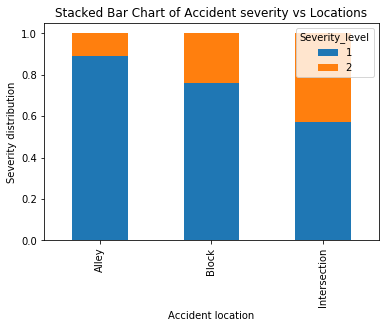

In [15]:
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
%matplotlib inline

table=pd.crosstab(df.Location_type,df.Severity_level)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Accident severity vs Locations')
plt.xlabel('Accident location')
plt.ylabel('Severity distribution')

**Findings:**

Intersections are dangerous.

**Check 3:**

### Severity distribution vs. weather

Text(0, 0.5, 'Severity distribution')

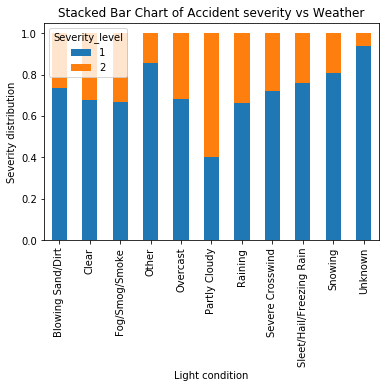

In [16]:
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
%matplotlib inline

table=pd.crosstab(df.Weather,df.Severity_level)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Accident severity vs Weather')
plt.xlabel('Light condition')
plt.ylabel('Severity distribution')

In [17]:
df[['Severity_level','Weather']].groupby('Weather').count()

Severity_level
Weather                                 
Blowing Sand/Dirt                     49
Clear                             109741
Fog/Smog/Smoke                       557
Other                                758
Overcast                           27424
Partly Cloudy                          5
Raining                            32812
Severe Crosswind                      25
Sleet/Hail/Freezing Rain             112
Snowing                              886
Unknown                            12368

**Findings:**
- the less risky weather is the snow: most likely the drivers are more careful and go slower
- party cloudy seems to be very risky, however as we have 5 accident categorized here, we could consider it as a lack of enogh data
- rainy weather seems to be considerably more dangerous than other weather types

**Check 4:**

### Severity distribution vs. light condition

Text(0, 0.5, 'Severity distribution')

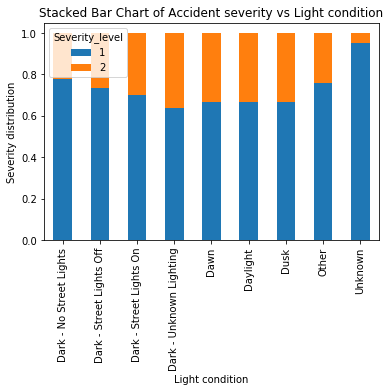

In [18]:
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
%matplotlib inline

table=pd.crosstab(df.Light_condition,df.Severity_level)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Accident severity vs Light condition')
plt.xlabel('Light condition')
plt.ylabel('Severity distribution')

**Findings:**
- strangely in the dark, without street lights is considerably more safe than in any other light conditions. 

**Check 5:**

### Severity distribution vs. road condition

Text(0, 0.5, 'Severity distribution')

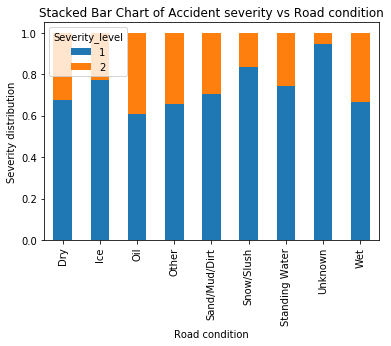

In [19]:
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
%matplotlib inline

table=pd.crosstab(df.Road_condition,df.Severity_level)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Accident severity vs Road condition')
plt.xlabel('Road condition')
plt.ylabel('Severity distribution')

**Findings:**
- Just like we saw at the Weather, in snow and ice drivers are more careful
- Oil is a big risk, as the drivers most likely are not prepared for it

**Check 6:**

### Severity distribution vs. hour

Text(0, 0.5, 'Severity distribution')

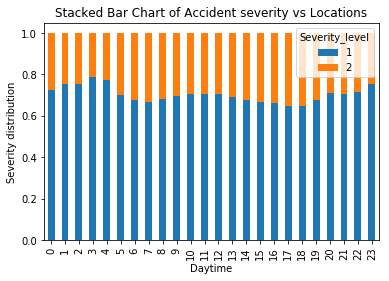

In [22]:
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
%matplotlib inline

table=pd.crosstab(df.Daytime,df.Severity_level)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Accident severity vs Locations')
plt.xlabel('Daytime')
plt.ylabel('Severity distribution')

**Findings:**
- it seems like the dawn, around 5-6AM and the evening around 6PM is somewhat more dangerous than the rest of the day

**Check 7:**

### Severity distribution vs. pedestrians, bikers and collision types

Text(0, 0.5, 'Severity distribution')

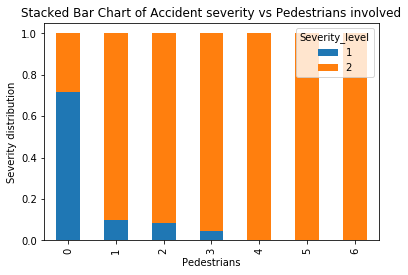

In [23]:
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
%matplotlib inline

table=pd.crosstab(df.Affected_pedestrians,df.Severity_level)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Accident severity vs Pedestrians involved')
plt.xlabel('Pedestrians')
plt.ylabel('Severity distribution')

Text(0, 0.5, 'Severity distribution')

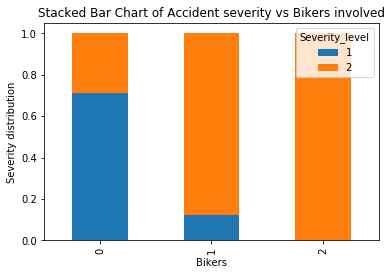

In [24]:
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
%matplotlib inline

table=pd.crosstab(df.Affected_bikers,df.Severity_level)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Accident severity vs Bikers involved')
plt.xlabel('Bikers')
plt.ylabel('Severity distribution')

Text(0, 0.5, 'Severity distribution')

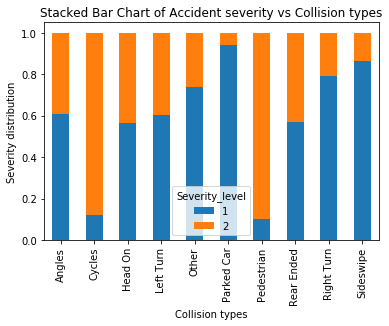

In [25]:
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
%matplotlib inline

table=pd.crosstab(df.Collision_type,df.Severity_level)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Accident severity vs Collision types')
plt.xlabel('Collision types')
plt.ylabel('Severity distribution')

**Findings:**
- each time a pedestrian or a biker involved in an accident, the chances are way higher to have a severe incident of course
- also it is worth to mention that if a parking car is involved in the accident, then it's most likely not serious in terms of injuries
- rear end collisions are serious, half of them ends with personal injuries


# Methodology

Now we have been working on the data for a while, we can be confident on choosing the proper model for creating the machine learning algorythm.

## Model expectations

- as we have two types of output, this is a **categorization**
- several independent variables are affecting a **single outcome variable**
- we are looking for a **probabilistic result**
- we need to know the **impact of a feature**

## Model selection

Based on our courses for categorization problems there are 2 models we should considerate:
- Logistic Regression Model
- SVM (Support Vestor Machine)

The **Logistic Regression Model** seems to be a perfect fit for our analysis, based on our expectations.



## Implementing Logistic Regression Model

Outcome field is already binary (column Severity_level, values 1 or 2)

### Choosing features

Based on our previous examinations, these are the selected features:

- Location_type
- Collision_type
- Inattention
- Under_influence
- Weather
- Road_condition
- Light_condition
- Pedestrian_right
- Speeding

These features were still under consideration:

- Affected_persons
- Affected_pedestrians
- Affected_bikers
- Affected_vehicles

However these are conesquences of the accidents, they are not actionable items.
We know, that we need to be extra careful with pedestrians and bikers, but this is nothing we could use for machine learning.


## Preparing data

Scikit requires data in Integer format, so we need to do some changes on the data.

 


In [29]:
import scipy.optimize as opt
from sklearn import preprocessing

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

accidents = df[['Severity_level', 'Location_type', 'Collision_type', 'Inattention', 'Under_influence', 'Weather', 'Road_condition', 'Light_condition', 'Pedestrian_right', 'Speeding']]



In [30]:
accidents.head()

Severity_level Location_type Collision_type Inattention Under_influence  \
0               2  Intersection         Angles         NaN               N   
1               1         Block      Sideswipe         NaN               0   
2               1         Block     Parked Car         NaN               0   
3               1         Block          Other         NaN               N   
4               2  Intersection         Angles         NaN               0   

    Weather Road_condition          Light_condition Pedestrian_right Speeding  
0  Overcast            Wet                 Daylight              NaN      NaN  
1   Raining            Wet  Dark - Street Lights On              NaN      NaN  
2  Overcast            Dry                 Daylight              NaN      NaN  
3     Clear            Dry                 Daylight              NaN      NaN  
4   Raining            Wet                 Daylight              NaN      NaN

## Checking missing values

In [33]:
accidents["Location_type"].replace('', np.nan, inplace=True)
accidents.dropna(subset=["Location_type"], inplace=True)

accidents.shape

(189032, 10)

In [34]:
accidents["Inattention"].replace({"Y": "1", np.nan: "0"}, inplace=True)
accidents.head()

accidents["Under_influence"].replace({"Y": "1", "N": "0", np.nan: "0"}, inplace=True)
accidents.head()

accidents["Inattention"].replace({"Y": "1", np.nan: "0"}, inplace=True)
accidents.head()

Severity_level Location_type Collision_type Inattention Under_influence  \
0               2  Intersection         Angles           0               0   
1               1         Block      Sideswipe           0               0   
2               1         Block     Parked Car           0               0   
3               1         Block          Other           0               0   
4               2  Intersection         Angles           0               0   

    Weather Road_condition          Light_condition Pedestrian_right Speeding  
0  Overcast            Wet                 Daylight              NaN      NaN  
1   Raining            Wet  Dark - Street Lights On              NaN      NaN  
2  Overcast            Dry                 Daylight              NaN      NaN  
3     Clear            Dry                 Daylight              NaN      NaN  
4   Raining            Wet                 Daylight              NaN      NaN

In [35]:
accidents[['Weather', 'Inattention']].groupby('Weather').count()



Inattention
Weather                              
Blowing Sand/Dirt                  49
Clear                          109741
Fog/Smog/Smoke                    557
Other                             758
Overcast                        27423
Partly Cloudy                       5
Raining                         32811
Severe Crosswind                   25
Sleet/Hail/Freezing Rain          112
Snowing                           886
Unknown                         12367

In [36]:
accidents["Weather"].replace({"Blowing Sand/Dirt": "Overcast", "Fog/Smog/Smoke": "Overcast", "Other": "Clear", "Partly Cloudy": "Overcast", "Severe Crosswind": "Overcast", "Sleet/Hail/Freezing Rain": "Raining", "Unknown": "Clear", np.nan: "Clear"}, inplace=True)
accidents[['Weather', 'Inattention']].groupby('Weather').count()




Inattention
Weather              
Clear          127164
Overcast        28059
Raining         32923
Snowing           886

In [37]:
accidents[['Road_condition', 'Inattention']].groupby('Road_condition').count()


Inattention
Road_condition             
Dry                  123037
Ice                    1183
Oil                      61
Other                   123
Sand/Mud/Dirt            74
Snow/Slush              987
Standing Water          109
Unknown               12220
Wet                   47008

In [38]:
accidents["Road_condition"].replace({"Ice": "Slippery", "Oil": "Slippery", "Other": "Dry", "Sand/Mud/Dirt": "Slippery", "Snow/Slush": "Slippery", "Unknown": "Dry", "Wet": "Slippery", np.nan: "Dry"}, inplace=True)
accidents[['Road_condition', 'Inattention']].groupby('Road_condition').count()



Inattention
Road_condition             
Dry                  139610
Slippery              49313
Standing Water          109

In [39]:
accidents["Light_condition"].replace({"Dark - No Street Lights": "Dark", "Dark - Street Lights Off": "Dark", "Dark - Street Lights On": "Intermediate", "Dark - Unknown Lighting": "Dark", "Dawn": "Intermediate", "Dusk": "Intermediate", "Other": "Intermediate", "Unknown": "Daylight", np.nan: "Daylight"}, inplace=True)
accidents[['Light_condition', 'Inattention']].groupby('Light_condition').count()

Inattention
Light_condition             
Dark                    2697
Daylight              129925
Intermediate           56410

In [40]:
accidents["Pedestrian_right"].replace({"Y": "1", np.nan: "0"}, inplace=True)
accidents[['Pedestrian_right', 'Inattention']].groupby('Pedestrian_right').count()

Inattention
Pedestrian_right             
0                      184406
1                        4626

In [41]:
accidents["Speeding"].replace({"Y": "1", np.nan: "0"}, inplace=True)
accidents[['Speeding', 'Inattention']].groupby('Speeding').count()

Inattention
Speeding             
0              179793
1                9239

In [42]:
accidents[['Collision_type', 'Inattention']].groupby('Collision_type').count()

Inattention
Collision_type             
Angles                34521
Cycles                 5332
Head On                2007
Left Turn             13635
Other                 23349
Parked Car            44764
Pedestrian             6482
Rear Ended            33612
Right Turn             2921
Sideswipe             18278

In [43]:
accidents["Collision_type"].replace({np.nan: "Other"}, inplace=True)
accidents[['Collision_type', 'Inattention']].groupby('Collision_type').count()

Inattention
Collision_type             
Angles                34521
Cycles                 5332
Head On                2007
Left Turn             13635
Other                 27480
Parked Car            44764
Pedestrian             6482
Rear Ended            33612
Right Turn             2921
Sideswipe             18278

In [44]:
accidents[['Location_type', 'Inattention']].groupby('Location_type').count()



Inattention
Location_type             
Alley                  747
Block               123890
Intersection         64395

In [46]:
accidents["Location_type"].replace({np.nan: "Other"}, inplace=True)
accidents[['Location_type', 'Inattention']].groupby('Location_type').count()

Inattention
Location_type             
Alley                  747
Block               123890
Intersection         64395

## Setting up the modell

1. separating features and outcome
2. prepare training and test sets
3. Applying OneHotEncoder

OneHotEncoder is needed to transform text values into numerical, SciKit's LogicRegression compatible

In [47]:
features = accidents[['Location_type', 'Collision_type', 'Inattention', 'Under_influence', 'Weather', 'Road_condition', 'Light_condition', 'Pedestrian_right', 'Speeding']]
outcome = accidents[['Severity_level']]



In [48]:
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.2, random_state=4)


print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (151225, 9) (151225, 1)
Test set: (37807, 9) (37807, 1)


In [51]:
X_train.head()

Location_type Collision_type Inattention Under_influence   Weather  \
82520          Block     Parked Car           1               0  Overcast   
40953          Block     Parked Car           0               0  Overcast   
13613          Block     Parked Car           0               0     Clear   
41824          Block        Head On           0               0     Clear   
106994  Intersection         Angles           0               0   Raining   

       Road_condition Light_condition Pedestrian_right Speeding  
82520             Dry        Daylight                0        0  
40953             Dry        Daylight                0        0  
13613             Dry        Daylight                0        0  
41824             Dry        Daylight                0        0  
106994       Slippery    Intermediate                0        0

In [60]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


categorical_columns = ['Location_type', 'Collision_type', 'Weather', 'Road_condition', 'Light_condition']
numerical_columns = ['Inattention', 'Under_influence', 'Pedestrian_right', 'Speeding']
preprocessing = make_column_transformer((OneHotEncoder(), categorical_columns), (SimpleImputer(), numerical_columns))
     
preprocessing.fit_transform(X_train)


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [61]:
preprocessing.fit_transform(X_test)


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [63]:
X_train = preprocessing.fit_transform(X_train)
X_test =preprocessing.fit_transform(X_test)


In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [65]:
yhat = LR.predict(X_test)
yhat

array([1, 2, 1, ..., 2, 1, 1])

In [66]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.93090148, 0.06909852],
       [0.11521857, 0.88478143],
       [0.8417161 , 0.1582839 ],
       ...,
       [0.4684877 , 0.5315123 ],
       [0.60294805, 0.39705195],
       [0.94019571, 0.05980429]])

In [67]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.7476657761790144

In [85]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[25651     0]
 [    0     0]]


In [84]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           1       0.75      0.97      0.84     26445
           2       0.77      0.23      0.35     11362

   micro avg       0.75      0.75      0.75     37807
   macro avg       0.76      0.60      0.60     37807
weighted avg       0.75      0.75      0.70     37807



In [71]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.4993475473034041

# Results

We have successfully developed a LR model, which took the input from the following columns:

- Location_type
- Collision_type
- Inattention
- Under_influence
- Weather
- Road_condition
- Light_condition
- Pedestrian_right
- Speeding


Based on our **classification report** the Severity_level = 1 is predicted with higher confidence than the Severity_level = 2.


# Discussion


There is a very important fact we need to be aware of:

## we do not have any information about the volume of the traffic.

This means we cannot inspect the volume of the accidents, only the ratio and causes of the Severity levels.


### The key takeaways from the exercise:

### Based on the geographical maps the most accidents happen here:
- Chinatown
- First Hill
- University District
- Lake City

### Most dangerous locations:
- Intersections
- High traffic streets
- Crosswalks

### Most dangerous times:
- early morning (5AM) and early evening (6PM)

### Other notable mentions:
- If pedestrians and bikers are involved in an accident, then it's almost surely serious with personal injuries


# Utilizing the information

In our Introduction we set up the goal to provide meaningful, actionable information for the **police department**, **real estate traders** and **insurance companies**.

Based on our analysis:

- Seattle Police department is provided with a list of dangerous places / type of places where leveraging presence or implementing traffic object changes, would help to reduce serious accidents

- Insurance companies have a good overview about how to implement changes based on car owners' address. 

- Real estate traders can argue with potentially safer environments.


# Conclusion


This was only a short introduction, based on the answers we got tons of new question which could be explored using other data sources - changes on traffic volume over the years, months or daytimes.